## System steup

In [75]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float

In [76]:
domain = '1ENH'
ref_pdb = f'/workspace7/torchmd-AD/crystals_dataset/crystals_short_16/level_0/ground_truth/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/crystals_dataset/topology_data/{domain}.psf'
#ref_xtc =  f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}_8kcenters.xtc'
#mol = Molecule(ref_xtc)
ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')

mol = ref_mol
#mol.read(ref_psf)
ref_mol.read(ref_psf)

In [77]:
mol.resname
length = len(mol.resname)
length

54

In [78]:
#for i in range(length-1):
#    print(np.sqrt(np.square(mol.coords[i] - mol.coords[i+1]).sum()))

In [79]:
#mol.read(ref_xtc)

In [80]:
mol = Molecule('/shared/carles/repo/torchmd-exp/data/cln/cln_ca_top_dih.psf')
mol.read('/shared/carles/repo/torchmd-exp/data/cln/cln_kcenters_8clusters_coords.xtc')
ref_mol = Molecule('/shared/carles/repo/torchmd-exp/data/cln/cln_ca.pdb')

In [81]:
# Compute starting coords
#[mol.dropFrames(1) for _ in range(32)]

mol.coords = np.expand_dims(mol.coords[:, : , 1], axis=-1)
mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)


print('Starting rmsd: ', rmsd(coords, native_coords))

Starting rmsd:  tensor(1.9902, device='cuda:0')


In [82]:
tm_score(coords, native_coords)

tensor(0.8319, device='cuda:0')

In [83]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [84]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))

In [85]:
system.pos

tensor([[[-121.5200,  152.8700,  112.8400],
         [-124.2400,  151.2000,  115.0800],
         [-121.3700,  150.8500,  117.6300],
         [-117.8500,  152.3100,  116.8800],
         [-116.3800,  150.2600,  119.7600],
         [-117.3500,  146.8600,  118.3800],
         [-117.0600,  148.5500,  114.8700],
         [-120.4600,  147.3800,  113.3600],
         [-121.4400,  149.7400,  110.6200],
         [-125.2900,  148.9700,  110.7700]]], device='cuda:0')

In [86]:
if torch.any(torch.isnan(system.pos)):
    raise RuntimeError("Found NaN coordinates.")

In [87]:
get_embeddings(mol, 'cpu', 1)

tensor([[ 4,  4,  5,  8,  6, 13,  2, 13,  7,  4]])

In [88]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/torchmd-exp/scripts/trainings/tests/test_crystals/crystals_16_levels/dih_general_tm_09_cutoff_24/'
nnp += 'epoch=683-train_loss=0.4471-val_loss=0.9037.ckpt'
embeddings = torch.tensor([ 4,  4,  5,  8,  6, 13,  2, 13,  7,  4]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [89]:
print('Number of parameters nnp: ', sum(p.numel() for p in external.model.parameters() if p.requires_grad))

Number of parameters nnp:  294565


In [90]:
from torchmd.forces import Forces
#external=None
forces = Forces(parameters,terms=['bonds', 'repulsioncg', 'dihedrals'], cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)
print(system.forces)

[48.453195571899414]
tensor([[[ -6.1329,   0.9977,   5.1348],
         [  8.6061,   5.2512,   0.2104],
         [ -1.7182,  -1.2953,  -2.4448],
         [ -1.8565,   3.1817,  -0.7890],
         [  5.2024,   6.6391,   6.0499],
         [ -0.8224,  -4.5113, -10.9048],
         [-10.9993,  -7.5662,   4.9344],
         [ 11.1297,  -2.3664,   8.3660],
         [-12.6672,  -1.5701,  -6.5080],
         [  9.2582,   1.2398,  -4.0489]]], device='cuda:0')


## Dynamics

In [91]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 350  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)


In [92]:
from torchmd.minimizers import minimize_bfgs

print(rmsd(system.pos, native_coords))
#minimize_bfgs(system, forces, steps=500)  # Minimize the system
print(rmsd(system.pos, native_coords))

tensor(1.9902, device='cuda:0')
tensor(1.9902, device='cuda:0')


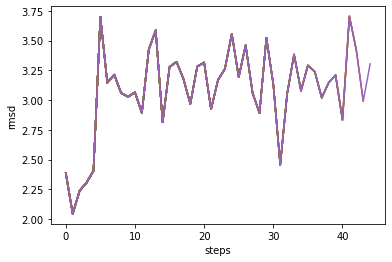

  4%|█▊                                       | 45/1000 [02:25<51:23,  3.23s/it]


KeyboardInterrupt: 

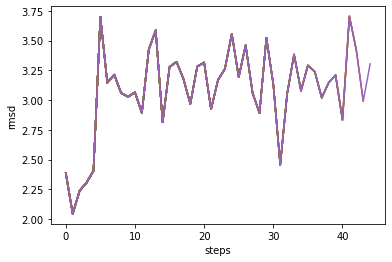

In [93]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 100
save_period = 10
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
Et = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    rmsds.append(rmsd(system.pos, native_coords).item())
    tm_scores.append(tm_score(system.pos, native_coords).item())
    Ep.append(Epot)
    Et.append(Ekin + Epot)
    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [69]:
#print(rmsds)

In [70]:
#print(tm_scores)

In [57]:
#pos_xtc = start_pos.detach().cpu().numpy().copy()
#mol.coords = np.moveaxis(pos_xtc, 0, -1)
#mol.write(f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}.pdb')

In [58]:
#mol.box = np.array([39.972, 39.941, 39.935], dtype=np.float32)

Text(0, 0.5, 'rmsd')

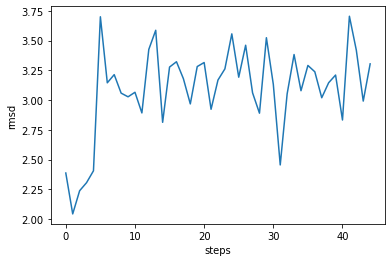

In [94]:
pl.plot(rmsds)
pl.xlabel('steps')
pl.ylabel('rmsd')

Text(0, 0.5, 'E')

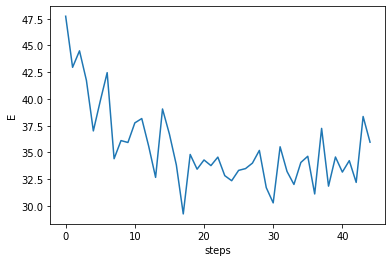

In [95]:
pl.plot(Ep)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

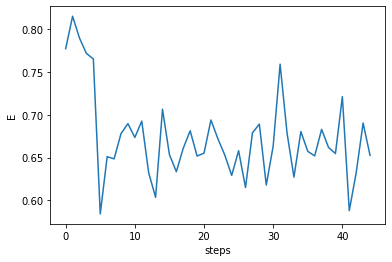

In [96]:
pl.plot(tm_scores)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

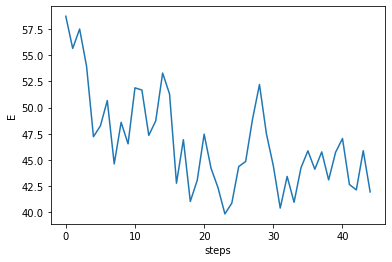

In [97]:
pl.plot(Et)
pl.xlabel('steps')
pl.ylabel('E')